<h1> HumanAI : Sentiment Analysis Twitter </h1>

In [1]:
pip install tweepy pandas nltk emoji

   ---------------------------------------- 0.0/590.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/590.6 kB ? eta -:--:--
   ----------------------------------- ---- 524.3/590.6 kB 2.1 MB/s eta 0:00:01
   ---------------------------------------- 590.6/590.6 kB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


<h3> Task 1: Social Media Data Extraction & Preprocessing (API Handling & Text Cleaning) </h3>

In [5]:
import tweepy
import pandas as pd
import re
import nltk
import emoji
from nltk.corpus import stopwords
from datetime import datetime, timedelta

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Twitter API credentials
bearer_token="your_twitter_api_bearer_token"

# Initialize client
client = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=True)

# Keywords related to mental health crises
keywords = ["depressed", "suicidal", "overwhelmed", "mental breakdown", "can't cope", 
            "hopeless", "addiction help", "relapse", "panic attack", "I give up", 
            "worthless", "anxiety", "substance abuse", "need help", "feeling lost"]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\devis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Build query string
query = "(" + " OR ".join([f'"{kw}"' for kw in keywords]) + ") lang:en -is:retweet"

# Set date range (last 7 days allowed in free access)
end_time = datetime.utcnow()
start_time = end_time - timedelta(days=7)

# Fetch tweets
tweets = []
count = 0
client = tweepy.Client(bearer_token=bearer_token, wait_on_rate_limit=False)


try:    
    for tweet in tweepy.Paginator(client.search_recent_tweets,
                                  query=query,
                                  tweet_fields=["id", "text", "created_at", "public_metrics", "geo"],
                                  expansions=["geo.place_id"],
                                  place_fields=["full_name", "country", "geo", "name"],
                                  max_results=10).flatten(limit=10):  # Adjust limit as needed
        count += 1
        if count % 50 == 0:
            print(f"{count} tweets fetched so far")
        content = tweet.text.lower()
        cleaned = re.sub(r"http\S+|www\S+|[^a-zA-Z\s]", "", content)
        cleaned = emoji.replace_emoji(cleaned, replace='')
        cleaned = ' '.join(word for word in cleaned.split() if word not in stop_words)

        tweets.append({
            "tweet_id": tweet.id,
            "timestamp": tweet.created_at,
            "content": content,
            "cleaned_content": cleaned,
            "likes": tweet.public_metrics["like_count"],
            "retweets": tweet.public_metrics["retweet_count"],
            "replies": tweet.public_metrics["reply_count"],
            "quotes": tweet.public_metrics["quote_count"],
            "geo": tweet.geo
        })
except tweepy.TooManyRequests:
    print("❌ Rate limit hit. Please wait 15 minutes before trying again.")

# Save to CSV
df = pd.DataFrame(tweets)
df.to_csv("C:/Users/devis/OneDrive/Desktop/twitter_crisis_posts_cleaned2.csv", index=False)
print("✅ Twitter data extracted and cleaned!")


C:\Users\devis\AppData\Local\Temp\ipykernel_31288\1979958979.py:5: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.utcnow()


❌ Rate limit hit. Please wait 15 minutes before trying again.
✅ Twitter data extracted and cleaned!


In [7]:
print(tweets)

[{'tweet_id': 1908433802893946895, 'timestamp': datetime.datetime(2025, 4, 5, 8, 17, 30, tzinfo=datetime.timezone.utc), 'content': "@tucker_and_otis @trumpdailyposts you can't hide job losses with dumb, worthless employment in the government post-doge. sorry", 'cleaned_content': 'tuckerandotis trumpdailyposts cant hide job losses dumb worthless employment government postdoge sorry', 'likes': 0, 'retweets': 0, 'replies': 0, 'quotes': 0, 'geo': None}, {'tweet_id': 1908433796556284369, 'timestamp': datetime.datetime(2025, 4, 5, 8, 17, 28, tzinfo=datetime.timezone.utc), 'content': '@aedcelectricity how long those it take to fix transformer at piwoyi na🥲😭\ni am depressed already, 1 month with no light is no joke', 'cleaned_content': 'aedcelectricity long take fix transformer piwoyi na depressed already month light joke', 'likes': 0, 'retweets': 0, 'replies': 0, 'quotes': 0, 'geo': None}, {'tweet_id': 1908433777757499739, 'timestamp': datetime.datetime(2025, 4, 5, 8, 17, 24, tzinfo=datetime.

<h3> Task 2: Sentiment & Crisis Risk Classification (NLP & Text Processing) </h3>

In [12]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def classify_sentiment(text):
    score = analyzer.polarity_scores(text)
    compound = score['compound']
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['cleaned_content'].apply(classify_sentiment)


In [14]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [15]:
high_risk = ["don’t want to be here", "end my life", "kill myself", "can’t take it anymore"]
moderate_risk = ["feel lost", "need help", "struggling", "anxious", "depressed"]
low_risk = ["mental health", "self care", "therapy", "burnout"]

def classify_risk(text):
    text = text.lower()
    if any(phrase in text for phrase in high_risk):
        return "High-Risk"
    elif any(phrase in text for phrase in moderate_risk):
        return "Moderate Concern"
    elif any(phrase in text for phrase in low_risk):
        return "Low Concern"
    else:
        return "Uncategorized"
    
df['risk_level'] = df['cleaned_content'].apply(classify_risk)

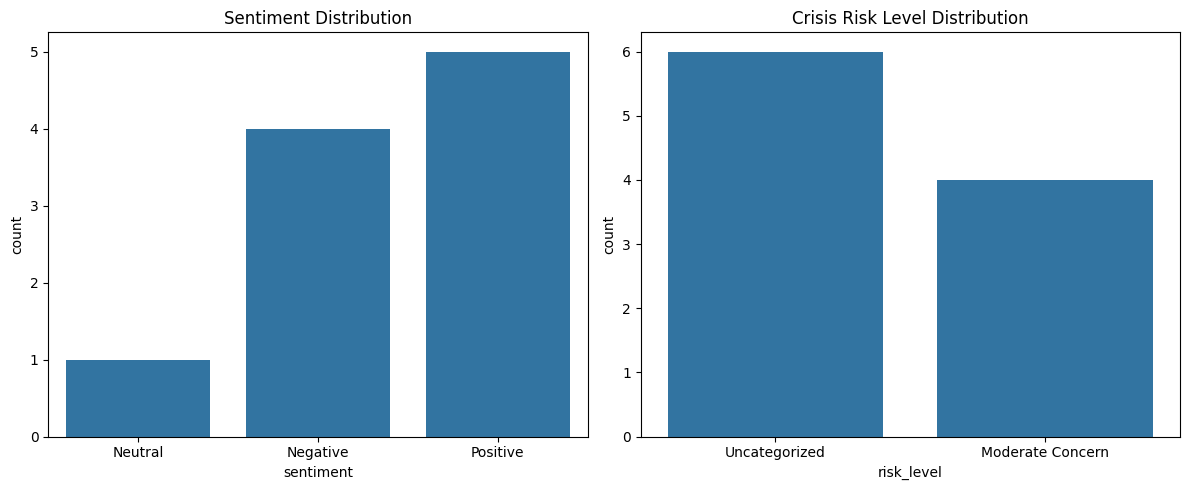

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=df, x='sentiment')
plt.title('Sentiment Distribution')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='risk_level')
plt.title('Crisis Risk Level Distribution')

plt.tight_layout()
plt.savefig("C:/Users/devis/OneDrive/Desktop/sentiment_risk_distribution.png")
plt.show()

<h3>Task 3: Crisis Geolocation & Mapping (Basic Geospatial Analysis & Visualization)</h3>

In [19]:
pip install spacy geopy folium

  Attempting uninstall: typer
    Found existing installation: typer 0.15.1
    Uninstalling typer-0.15.1:
      Successfully uninstalled typer-0.15.1
Note: you may need to restart the kernel to use updated packages.


In [21]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 2.8 MB/s eta 0:00:05
     -- ------------------------------------- 0.8/12.8 MB 1.2 MB/s eta 0:00:11
     --- ------------------------------------ 1.0/12.8 MB 1.3 MB/s eta 0:00:10
     ---- ----------------------------------- 1.3/12.8 MB 1.3 MB/s eta 0:00:09
     ----- ---------------------------------- 1.8/12.8 MB 1.5 MB/s eta 0:00:08
     ------ --------------------------------- 2.1/12.8 MB 1.5 MB/s eta 0:00:08
     ------- -------------------------------- 2.4/12.8 MB 1.5 MB/s eta 0:00:07
     -------- ------------------------------- 2.6/12.8 MB 1.5 MB/s eta 0:00:07
     --------- ------------------------------ 2.9/12.8 MB 1.4 MB/s eta 0:00:07
     --------- ------------------------------ 3.1/12.8 MB 1.4 MB/s eta 0:00:07
     --------- ------------------------------ 3.1/12.8 MB 1.4 MB/s

In [34]:
import spacy
import pandas as pd

# Load spaCy NER
nlp = spacy.load("en_core_web_sm")

# Load your dataset
df = pd.read_csv("C:/Users/devis/OneDrive/Desktop/twitter_crisis_posts_cleaned.csv")

# Step 1a: spaCy NER for location extraction
def extract_location(text):
    doc = nlp(str(text))
    for ent in doc.ents:
        if ent.label_ == "GPE":
            return ent.text
    return None

df['location_text'] = df['content'].apply(extract_location)

# Step 1b: Fallback using keyword dictionary
place_keywords = {
    "austin": "Austin, TX",
    "new york": "New York, NY",
    "toronto": "Toronto, Canada",
    "los angeles": "Los Angeles, CA",
    "houston": "Houston, TX",
    "chicago": "Chicago, IL",
    "vancouver": "Vancouver, Canada"
    # Add more based on expected locations
}

def keyword_location(text):
    text = str(text).lower()
    for key in place_keywords:
        if key in text:
            return place_keywords[key]
    return None

df['location_text'] = df['location_text'].fillna(df['content'].apply(keyword_location))

In [35]:
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="gsoc_geolocator")
def geocode_location(place):
    try:
        location = geolocator.geocode(place)
        if location:
            return pd.Series([location.latitude, location.longitude])
    except:
        return pd.Series([None, None])
    time.sleep(1)  # avoid hitting rate limit

df[['latitude', 'longitude']] = df['location_text'].apply(geocode_location)

In [36]:
import folium
from folium.plugins import HeatMap

# Filter rows with coordinates
map_df = df.dropna(subset=['latitude', 'longitude'])

# Initialize map
m = folium.Map(location=[39.5, -98.35], zoom_start=4)  # Center of US

# Add heatmap
heat_data = [[row['latitude'], row['longitude']] for _, row in map_df.iterrows()]
HeatMap(heat_data).add_to(m)

# Save or display
m.save("C:/Users/devis/OneDrive/Desktop/crisis_heatmap.html")

In [ ]:
top_locations = df['location_text'].value_counts().head(5)
print("Top 5 Crisis Locations:")
print(top_locations)